In [1]:
import numpy as np
import math
import copy
import numpy.linalg as LA
import time
import random
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

from tqdm import tqdm

# Classification

In [2]:
ambientDimension = 100
sigma = 0.5 # noise power
numAvg = int(1 * 1e+0) # number of average
base_train_num = 30

featureMean = np.zeros(ambientDimension)

# Testing Isotropic data 
a_test = 1
Cov1, Cov2 = np.identity(ambientDimension), np.identity(ambientDimension)
decay = .9
for i in range(ambientDimension):
    Cov1[i, i] = decay ** (i - 1)
for i in range(ambientDimension)[::-1]:
    Cov2[i, i] = decay ** (i - 1)
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        Cov1[i, i] = 0
#    else:
#        Cov2[i, i] = 0


featureCov = a_test * Cov1 + (1 - a_test) * Cov2
# sparse signal
#p = 0.2
#diag = np.diag(np.diag(featureCov))
#featureCov = (1 - p) ** 2 * (featureCov - diag) + (1 - p) * diag

#featureCov = np.identity(ambientDimension)
betaStar = np.random.multivariate_normal(featureMean, featureCov).reshape(-1,1)
betaStar /= LA.norm(betaStar)

#betaStar = np.ones([ambientDimension, 1])
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        betaStar[i, 0] = -1
#betaStar /= LA.norm(betaStar)

# sparsity
#for i in range(ambientDimension):
#    a = random.random()
#    if a <= 0.9:
#        betaStar[i] = 0
#betaStar /= LA.norm(betaStar)
        

# Nonisotropic data (comment this block if istropic data is used)
#featureCov = np.identity(ambientDimension)
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        featureCov[i,i] = 1
#betaStar =  np.zeros(ambientDimension).reshape(-1,1)
#betaStar[0] = 0.1
#betaStar[-1] = 1

# training data
train_mean = np.zeros(ambientDimension)
a_train = 1
#train_cov = np.identity(ambientDimension)
#for i in range(ambientDimension):
#    if i <= int(ambientDimension/2):
#        train_cov[i,i] = 0.2

In [3]:
# Estimator Function
def getRidgeEst(X, y, yc, ridge):
    d = X.shape[1]
    n = X.shape[0]
    idm = np.identity(d)
    #for i in range(ambientDimension):
    #    if i <= int(ambientDimension/2):
    #        idm[i, i] = 0

    S = LA.pinv(X.T.dot(X) + n * ridge * idm).dot(X.T)
    return S.dot(y), S.dot(yc)

def getLSEst(X, y):
    Cov = X.T.dot(X)
    #d = X.shape[1]
    # faster LSE approximation
    #est = LA.inv(Cov+1e-10*np.identity(d)).dot(X.T.dot(y))
    S = LA.pinv(Cov).dot(X.T)
    return S.dot(y)

def getCropEst(X, y, yc, p):
    Cov = X.T.dot(X)
    d, n = X.shape[1], X.shape[0]
    diag = np.diag(np.diag(Cov))
    #Cov = n * featureCov
    a = 0
    Z = a * Cov + (1 - a) * ((1-p) * Cov + p * diag)
    
    #d, n = X.shape[1], X.shape[0]
    #ridge = 0.1
    #Z = Z + n * ridge * np.identity(d)
    
    S = LA.pinv(Z).dot((1 - p) * X.T)
    return S.dot(y), S.dot(yc) 

def get_crop_finite_iter(X, n0, n1, p):
    X0 = copy.deepcopy(X)
    x = X[n1 % n0, :] * bernoulli.rvs(1-p, size=ambientDimension)
    X0 = np.concatenate((X0, x.reshape(1, -1)), axis=0)
    return X0
    
def get_crop_finite_data(X, y, n1, p):
    n0 = X.shape[0]
    X0 = copy.deepcopy(X)
    y0 = copy.deepcopy(y)
    y_label = []
    for i in range(n0):
        y_label += [[y0[i, 0], i]]
    for i in range(n1):
        x = X0[i % n0, :] * bernoulli.rvs(1-p, size=ambientDimension)
        y1 = y0[i % n0, :]
        y_label += [[y1[0], i % n0]]
        X0 = np.concatenate((X0, x.reshape(1, -1)), axis=0)
        y0 = np.concatenate((y0, y1.reshape(1, -1)), axis=0)
    return X0, y0, y_label

def get_gauss_finite_data(X, y, n1, ridge):
    n0 = X.shape[0]
    X0 = copy.deepcopy(X)
    y0 = copy.deepcopy(y)
    y_label = []
    for i in range(n0):
        y_label += [[y0[i, 0], i]]
    for i in range(n1):
        x = X0[i % n0, :] + ridge * np.random.multivariate_normal(np.zeros(ambientDimension), np.identity(ambientDimension))
        y1 = y0[i % n0, :]
        y_label += [[y1[0], i % n0]]
        X0 = np.concatenate((X0, x.reshape(1, -1)), axis=0)
        y0 = np.concatenate((y0, y1.reshape(1, -1)), axis=0)
    return X0, y0, y_label
    
# Uitlity Functions

def getMask(k, p):
    mean_mask = 0
    for i in range(k):
        mean_mask += bernoulli.rvs(1-p, size=ambientDimension)
    return mean_mask / k

# Risk

def getRisk(beta, X_test, y_test):
    risk = 0
    num_test = X_test.shape[0]
    for i in range(num_test):
        if y_test[i] * (np.inner(X_test[i, :], beta.reshape(-1))) < 0:
            risk += 1
        elif y_test[i] * (np.inner(X_test[i, :], beta.reshape(-1))) == 0:
            risk += 0.5
    risk /= num_test
    return risk

def get_risk(beta):
    z = np.inner(beta.reshape(-1), betaStar.reshape(-1)) / math.sqrt(2) / math.sqrt(beta.T.dot(featureCov).dot(beta)[0])
    return 0.5 * (1 - math.erf(z))

def getExpRisk(numSampling, numIter, paraList, modeDA):
    risk = np.zeros([numIter, len(paraList)])
    riskLSE = np.zeros(numIter)
            
    for t in range(numIter):
        X = np.zeros([numSampling, ambientDimension])
        y = np.zeros([numSampling, 1])
        for i in range(numSampling):
            z = random.random()
            y[i, 0] = -1 if z <= 0.5 else 1
            X[i, :] = (betaStar * y[i, 0] + np.random.multivariate_normal(np.zeros(ambientDimension), featureCov).reshape(-1, 1)).reshape(-1)
        X0 = X[:base_train_num, :] # base sample
        y0 = y[:base_train_num, :]
        
        # generate test data
        #num_test = 100
        #y_test = np.zeros(num_test)
        #X_test = np.zeros([num_test, ambientDimension])
        #for j in range(num_test):
        #    z = random.random()
        #    y_test[j] = -1 if z <= 0.5 else 1
        #    X_test[j, :] = (betaStar * y_test[j] + np.random.multivariate_normal(np.zeros(ambientDimension), featureCov).reshape(-1, 1)).reshape(-1)
        
        # baseline LSE
        beta_est = getLSEst(X, y)
        riskLSE[t] = get_risk(beta_est)
        
        for j in range(len(paraList)):
            if numSampling > base_train_num:
                n1 = numSampling - base_train_num
                if modeDA == "crop":
                    X1, y1 = get_crop_finite_data(X0, y0, n1, paraList[j])
                elif modeDA == "ridge":
                    X1, y1 = get_gauss_finite_data(X0, y0, n1, paraList[j]) 
            else:
                X1, y1 = X, y
           
            beta_est = getLSEst(X1, y1)
            risk[t, j] = get_risk(beta_est)
    return risk.mean(axis=0), riskLSE.mean()

def get_exp_risk(numSampling, numIter, para_ridge, para_crop):
    risk_ridge = np.zeros([numIter, len(para_ridge)])
    risk_crop = np.zeros([numIter, len(para_crop)])
    riskLSE = np.zeros(numIter)
            
    for t in range(numIter):
        
        # training sample generation
        X = np.zeros([numSampling, ambientDimension])
        y = np.zeros([numSampling, 1])
        for i in range(numSampling):
            z = random.random()
            y[i, 0] = -1 if z <= 0.5 else 1
            X[i, :] = (betaStar * y[i, 0] + np.random.multivariate_normal(np.zeros(ambientDimension), featureCov).reshape(-1, 1)).reshape(-1)
        X0 = X[:base_train_num, :] # base sample
        y0 = y[:base_train_num, :]

        # baseline LSE
        beta_est = getLSEst(X, y)
        riskLSE[t] = get_risk(beta_est)
        
        for j in range(len(para_ridge)):
            n1 = numSampling - base_train_num
            X1, y1, y1_label = get_gauss_finite_data(X0, y0, n1, para_ridge[j])
            beta_est = getLSEst(X1, y1)
            risk_ridge[t, j] = get_risk(beta_est)
            
        for j in range(len(para_crop)):
            n1 = numSampling - base_train_num
            X2, y2, y2_label = get_crop_finite_data(X0, y0, n1, para_crop[j])
           
            beta_est = getLSEst(X2, y2)
            risk_crop[t, j] = get_risk(beta_est)
    return risk_ridge.mean(axis=0), risk_crop.mean(axis=0), riskLSE.mean(), X0, y0, X1, y1_label, X2, y2_label


In [4]:
# Choose the type of augmentation:

# set range of parameters of DA
# "crop_finite": dropout with k fixed patterns, "crop": dropout with p dropout rate, 
# "ridge": add gaussian with power sigma s^2, "proj": random projection with k dimensional space,
# "mixup": mix-up with beta distribution parameter b
ridge_params = np.power(2, np.linspace(-10, 10, num=10))
ridge_params = [1]
crop_params = np.concatenate((np.linspace(0, 0.4, num=4), np.linspace(.5, 1, num=5)))
crop_params = [0.4]


In [5]:
sample = range(5, 4 * ambientDimension, 20)
risk_ridge_List = list()
risk_crop_List = list()
riskLseList = list()

# Simulate risk
np.random.seed(1)
count = 0
start = time.time()
for i in tqdm(sample):
    risk_ridge, risk_crop, risk_lse, X0, y0, X1, y1_label, X2, y2_label = get_exp_risk(i, numAvg, ridge_params, crop_params)
    risk_ridge_List.append(risk_ridge)
    risk_crop_List.append(risk_crop)
    riskLseList.append(risk_lse)
    count += 1
    # print('Complete {} %'.format(round(count*100/len(sample), 1)))
end = time.time()
print('Complete in {} sec'.format(round(end-start, 2)))

100%|██████████| 20/20 [00:28<00:00,  1.42s/it]

Complete in 28.36 sec


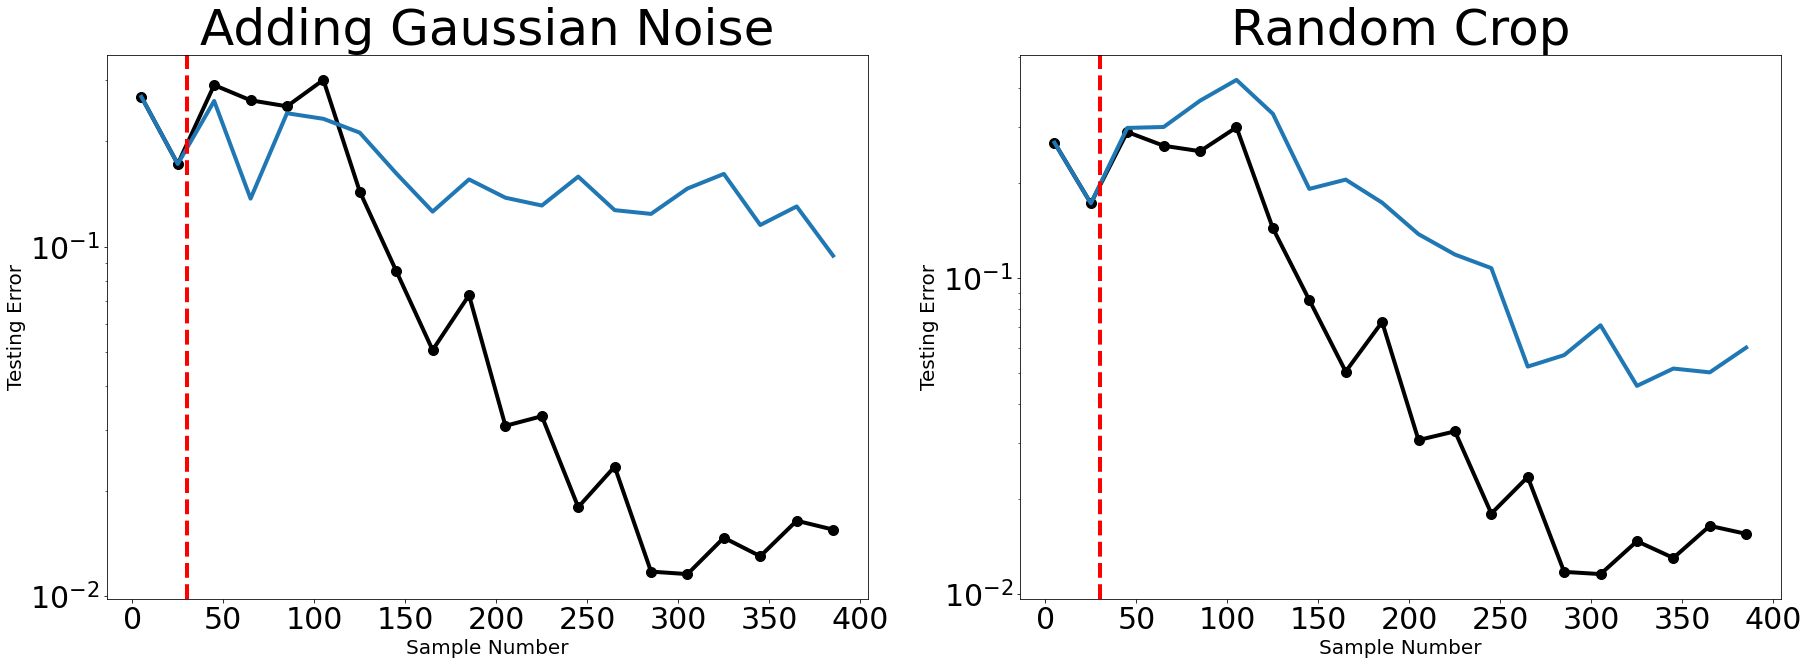

In [6]:
risk_ridge_table = np.zeros([len(sample),len(ridge_params)])
for i in range(len(sample)):
    for j in range(len(ridge_params)):
        risk_ridge_table[i,j] = risk_ridge_List[i][j]
        
risk_crop_table = np.zeros([len(sample),len(crop_params)])
for i in range(len(sample)):
    for j in range(len(crop_params)):
        risk_crop_table[i,j] = risk_crop_List[i][j]

plt.figure(figsize=(30, 10))
plt.subplot(1,2,1)
plt.plot(sample, riskLseList, label="LSE", color='black', marker='o', markersize=10, linewidth=4.0) 
for i in range(0, len(ridge_params)):
    plt.plot(sample, risk_ridge_table[:,i], label=r'$\sigma=$'+str(round(np.sqrt(ridge_params[i]),3)), linewidth=4.0) # Gaussian noise
    plt.yscale("log")   
plt.axvline(x=base_train_num, label='virtual sample threshold = ' + str(base_train_num), c='red', ls='--', linewidth=4.0)
#plt.legend(loc="upper right", prop={'size': 15})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Testing Error', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Adding Gaussian Noise", fontsize=50)
#plt.ylim(1 * 1e-2,1e0)

plt.subplot(1,2,2)
plt.plot(sample, riskLseList, label="LSE", color='black', marker='o', markersize=10, linewidth=4.0) 
for i in range(0, len(crop_params)):
    plt.plot(sample, risk_crop_table[:,i],label=r'$p=$'+str(round(crop_params[i],3)), linewidth=4.0) # Random crop
    plt.yscale("log")   
plt.axvline(x=base_train_num, label='virtual sample threshold = ' + str(base_train_num), c='red', ls='--', linewidth=4.0)
#plt.legend(loc="lower left", prop={'size': 15})
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Testing Error', fontsize=20)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Random Crop", fontsize=50)
#plt.ylim(1 * 1e-2,1e0)

plt.show()

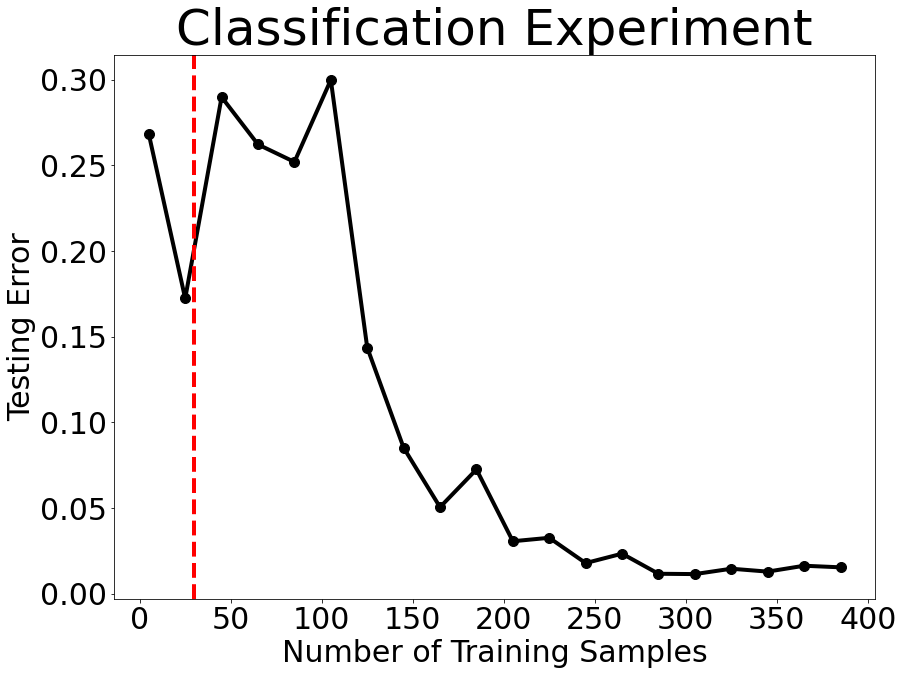

In [7]:
plt.figure(figsize=(30, 10))
plt.subplot(1,2,1)
plt.plot(sample, riskLseList, label="LSE", color='black', marker='o', markersize=10, linewidth=4.0)   
plt.axvline(x=base_train_num, label='virtual sample threshold = ' + str(base_train_num), c='red', ls='--', linewidth=4.0)
#plt.legend(loc="upper right", prop={'size': 15})
plt.xlabel('Number of Training Samples', fontsize=30)
plt.ylabel('Testing Error', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Classification Experiment", fontsize=50)
#plt.ylim(1 * 1e-2,)


plt.show()

In [8]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [9]:
writer.add_embedding(X0, metadata=y0, tag='original')
writer.add_embedding(X1, metadata=y1_label, tag='add_gaussian', metadata_header=['class', 'id'])
writer.add_embedding(X2, metadata=y2_label, tag='random_crop', metadata_header=['class', 'id'])

In [10]:
#!tensorboard --logdir=runs (copy and paste this line to the terminal and click enter to open the tensorboard)